Distribution of MI scores of entries in several thesauri. Do thesauri just happen to contain better features?

In [1]:
%cd ~/NetBeansProjects/thesisgenerator/
from thesisgenerator.utils.conf_file_utils import parse_config_file
from thesisgenerator.utils.data_utils import get_tokenized_data, get_tokenizer_settings_from_conf
from thesisgenerator.plugins.bov import ThesaurusVectorizer
from discoutils.thesaurus_loader import Vectors
from sklearn.feature_selection import f_classif, chi2
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from thesisgenerator.utils.misc import calculate_log_odds
from scipy.sparse import csr_matrix
%matplotlib inline

/Users/miroslavbatchkarov/NetBeansProjects/thesisgenerator


In [2]:
conf, configspec_file = parse_config_file('conf/exp1/exp1_base.conf')
tr_data = conf['training_data'] + '.gz'
xtr, ytr, _, _ = get_tokenized_data(tr_data,
                                        get_tokenizer_settings_from_conf(conf))

X, vocab = ThesaurusVectorizer(min_df=0).fit_transform(xtr)

In [3]:
fvalues, pvalues = f_classif(X, ytr)

In [4]:
scores = {}
paths = ['../FeatureExtractionToolkit/exp10-13-composed-ngrams/AN_NN_gigaw-100_Baroni.events.filtered.strings',
        '../FeatureExtractionToolkit/exp10-13-composed-ngrams/AN_NN_gigaw-100_Add.events.filtered.strings',
        '../FeatureExtractionToolkit/exp10-13-composed-ngrams/AN_NN_gigaw-100_Left.events.filtered.strings',
        '../FeatureExtractionToolkit/exp10-13-composed-ngrams/AN_NN_gigaw-100_Right.events.filtered.strings']
for path in paths:
    v = Vectors.from_tsv(path)
    scores_this_composer = []
    for i, (df, idx) in enumerate(vocab.items()):
        if df in v:
            scores_this_composer.append(fvalues[idx])
    scores[path] = scores_this_composer

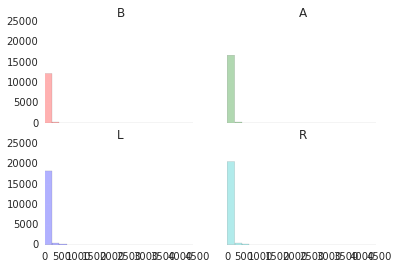

In [5]:
f, axes = plt.subplots(2, 2, sharey=True, sharex=True)
names, colors = 'BALR', 'rgbc'
for i, (_, vals) in enumerate(scores.items()):
    axes.flat[i].hist(vals, bins=20, alpha=.3, color=colors[i]);
    axes.flat[i].set_title(names[i])
plt.savefig('midist.pdf', format='pdf')

In [6]:
X1 = [
        [1, 1, 0, 0],
        [1, 1, 1, 0],
        [0, 1, 1, 1],
        [0, 0, 1, 1],
    ]
y1 = np.array([0, 0, 1, 1])
f_classif(X1, y1)

(array([ inf,   1.,   1.,  inf]),
 array([ 0.        ,  0.42264973,  0.42264973,  0.        ]))

In [7]:
calculate_log_odds(csr_matrix(X1), y1)

array([ 14.50865824,   0.69314668,  -0.69314668, -14.50865824])

# what happens to good classifier features when redirected through a thesaurus

shape is (79800, 879546)


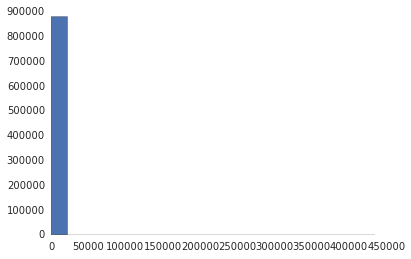

In [8]:
# are very informative features (ones strongly associated with class C)
# replaced by other informative feats or not?
print('shape is', X.shape)
a, b = chi2(X, ytr) # small values of A mean informative features
plt.hist(a, bins=20);

In [9]:
ytr[ytr != 'Automotive'] = 'NotAutomotive' # lo_score assumes two classes, let's make it that was
# pre-select features using chi2 (much faster, but selects both positive and negative features)
premask, _ = chi2(X, ytr)
premask = np.argsort(premask)[:1000]
%time lo_automotive = calculate_log_odds(X, ytr, column_indices=premask)

CPU times: user 1.22 s, sys: 8.99 ms, total: 1.23 s
Wall time: 1.23 s


27100.934131930349

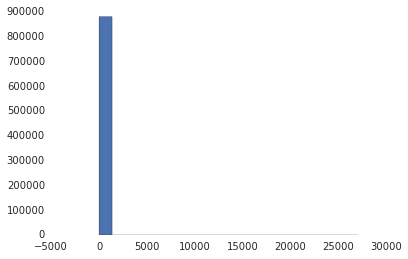

In [10]:
plt.hist(lo_automotive, bins=20);
max(lo_automotive)

In [16]:
lo_automotive[np.asarray(X.sum(axis=0)).ravel() < 5] = 0 # de-select infreq features
# lets look at the informative features
inv_vocab = {v:k for k,v in vocab.items()}
good_feats_idx = np.argsort(lo_automotive)[:40] # index of 100 most informative features (either for or against automotive)
good_feats = set(str(inv_vocab[idx]) for idx in good_feats_idx)
good_feats

{'back-up/N',
 'bandanna/N',
 'basic/J_cover/N',
 'blink/N',
 'brand-new/J',
 'control/N_knob/N',
 'corp/N',
 'cut/V_inch/N',
 'day/N_light/N',
 'flexible/J_hose/N',
 'fr/N',
 'hard/J_shell/N',
 'hazy/J',
 'help/V_issue/N',
 'ho/N',
 'little/J_lift/N',
 'longer/J_length/N',
 'low/J_grade/N',
 'match/V_photo/N',
 'metal/N_pipe/N',
 'mildew/N_smell/N',
 'nfl/N',
 'oct/N',
 'order/V_right/N',
 'particulate/N',
 'pice/N',
 'plastic/J_foot/N',
 'portable/J_player/N',
 'pre-filter/J',
 'raise/N',
 'raise/V_child/N',
 'receive/V_ball/N',
 'run/V_house/N',
 'screw-in/J',
 'shiping/N',
 'status/N',
 'tight/J_water/N',
 'unavoidable/J',
 'unreal/J',
 'wwii/N'}

In [12]:
v = Vectors.from_tsv('../FeatureExtractionToolkit/word2vec_vectors/composed/AN_NN_word2vec-wiki_15percent-rep0_Add.events.filtered.strings')

In [17]:
phrases = [str(s) for s in vocab.keys()]
v.init_sims(vocab=phrases, n_neighbors=len(good_feats_idx))

In [18]:
lengths = []
for feat in good_feats:
    neigh = v.get_nearest_neighbours(feat)
    if neigh:
        neigh = set(x[0] for x in neigh)
        inters = neigh.intersection(good_feats)
        lengths.append(len(inters))
#         print(feat, 'inters', inters)
#     else:
#         print('no neigh for', feat)
print(np.mean(lengths))

0.0


In [15]:
X.shape

(79800, 879546)